In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!mkdir Amostra
!cp /content/drive/My\ Drive/Resnet/Amostra_6_classes_split_v3.zip /content/Amostra/
%cd /content/Amostra/
!unzip -q Amostra_6_classes_split_v3.zip
!rm /content/Amostra/Amostra_6_classes_split_v3.zip

^C


In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

from torch.optim import lr_scheduler

In [ ]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

In [ ]:
def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms
    

In [ ]:
def data_augmentation_preprocess(mean, std):
    
    initail_transoform = transforms.RandomChoice([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(90)
        ])
    
    common_transforms = image_common_transforms(mean, std)
                
    aug_transforms = transforms.Compose([
        initail_transoform,
        transforms.RandomGrayscale(p=0.1),
        common_transforms
        ])
    
    return aug_transforms

In [ ]:
def get_mean_std(data_root, num_workers=4):
    
    transform = image_preprocess_transforms()
    
    loader = data_loader(data_root, transform)

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

In [ ]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

In [ ]:
def subset_data_loader(data_root, transform, batch_size=8, shuffle=False, num_workers=2, subset_size=0.05):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    data_subset = torch.utils.data.Subset(dataset,np.arange(0,len(dataset),1./subset_size).astype(int))

    loader = torch.utils.data.DataLoader(data_subset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

In [ ]:
def get_data(batch_size, data_root, num_workers=4, data_augmentation=False):
    train_data_path = os.path.join(data_root, 'training')
       
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = image_common_transforms(mean, std) 
        
    # train dataloader
    #train_loader = subset_data_loader(train_data_path, train_transforms, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
    #                   subset_size=0.2)
    train_loader = data_loader(train_data_path, 
                               train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')

    mean_test, std_test = get_mean_std(data_root=test_data_path, num_workers=num_workers)

    common_transforms_test = image_common_transforms(mean_test, std_test)    


    #test_loader = subset_data_loader(test_data_path, common_transforms_test, batch_size=batch_size, shuffle=True, num_workers=num_workers, 
    #                   subset_size=0.2)
    test_loader = data_loader(test_data_path, 
                              common_transforms_test, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)

    return train_loader, test_loader

# <font style="color:blue">Train</font>


In [ ]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

### <font style="color:green">Training Configuration</font>

In [ ]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 500 
    epochs_count: int = 50  
    init_learning_rate: float = 0.0001  # initial learning rate for lr scheduler
    decay_rate: float = 0.1
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/content/Amostra" 
    num_workers: int = 2 
    device: str = 'cuda'  
    dst_root: str = '/content/drive/My Drive/Resnet/8.2-classificacao_v5(6_classes)/6_classes'
    


In [ ]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">Training Function</font>


In [ ]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:blue">Validation Function</font>

In [ ]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Perda Média (Average loss): {:.4f}, Precisão: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:blue">Save the Model</font>

In [ ]:
def save_model(model, device, model_dir='models/', model_file_name='CIPP_classifier_6_classes.pt'):
    

#    if not os.path.exists(model_dir):
#        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    #print(model_path)
    torch.save(model.state_dict(), model_path)

    if device == 'cuda':
        model.to('cuda')
    
    return

## <font style="color:blue">Load the Model</font>

In [ ]:
def load_model(model, model_dir='models', model_file_name='CIPP_classifier_6_classes.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

## <font style="color:blue">Main Function for Training</font>



In [ ]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=True):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
#         Calculate Initial Test Loss
        init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
        print("Perda inicial da validação : {:.6f}, \nPrecisão inicial da validação : {:.3f}%\n".format(init_val_loss, init_val_accuracy*100))
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Modelo melhorado. Salvando o Modelo...\n')
                os.chdir(training_configuration.dst_root)
                save_model(model, device=training_configuration.device)
                os.chdir(training_configuration.data_root)
        
                
    print("Tempo total: {:.2f}, Melhor perda: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:blue">Plot Loss and Accuracy</font>

In [ ]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="Perda no treinamento ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="Perda na validação ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('perda')
    plt.legend(loc=loss_legend_loc)
    plt.title('Perda no Treinamento e na Validação')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="Precisão no treinamento ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="Precisão na validação ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('Precisão')
    plt.legend(loc=acc_legend_loc)
    plt.title('Precisão do Treinamento e da Validação')
    os.chdir(training_configuration.dst_root)
    fig.savefig('sample_loss_acc_plot.png')
    os.chdir(training_configuration.data_root)
    plt.show()
    
    return   

In [ ]:
def pretrained_resnet50(transfer_learning=True, num_class=6):
    resnet = models.resnet50(pretrained=True)
    
    if transfer_learning:
        for param in resnet.parameters():
            param.requires_grad = False
            
    last_layer_in = resnet.fc.in_features
    resnet.fc = nn.Linear(last_layer_in, num_class)
    
    return resnet

## <font style="color:red">Training</font>


In [ ]:
model = pretrained_resnet50()
print(model)

# get optimizer
train_config = TrainingConfiguration()



# optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate
)

decay_rate=train_config.decay_rate

lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [ ]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, scheduler=scheduler, data_augmentation=True)

mean: tensor([0.4989, 0.4909, 0.4811]), std: tensor([0.1985, 0.1947, 0.1935])
mean: tensor([0.4987, 0.4905, 0.4804]), std: tensor([0.1982, 0.1941, 0.1927])

Test set: Perda Média (Average loss): 1.8488, Precisão: 539/10272 (5%)

Perda inicial da validação : 1.848844, 
Precisão inicial da validação : 5.247%

Epoch: 0 
Train Loss: 1.119886 Acc: 0.6778
Elapsed 488.89s, 488.89 s/epoch, 5.89 s/batch, ets 23955.73s

Test set: Perda Média (Average loss): 0.6660, Precisão: 9565/10272 (93%)

Modelo melhorado. Salvando o Modelo...


Test set: Perda Média (Average loss): 0.6660, Precisão: 9565/10272 (93%)

Perda inicial da validação : 0.666015, 
Precisão inicial da validação : 93.117%

Epoch: 1 
Train Loss: 0.541425 Acc: 0.9365
Elapsed 1072.09s, 536.05 s/epoch, 6.46 s/batch, ets 25730.17s

Test set: Perda Média (Average loss): 0.3701, Precisão: 9775/10272 (95%)

Modelo melhorado. Salvando o Modelo...


Test set: Perda Média (Average loss): 0.3701, Precisão: 9775/10272 (95%)

Perda inicial da vali

## <font style="color:blue">Loss and Accuracy Plot</font>

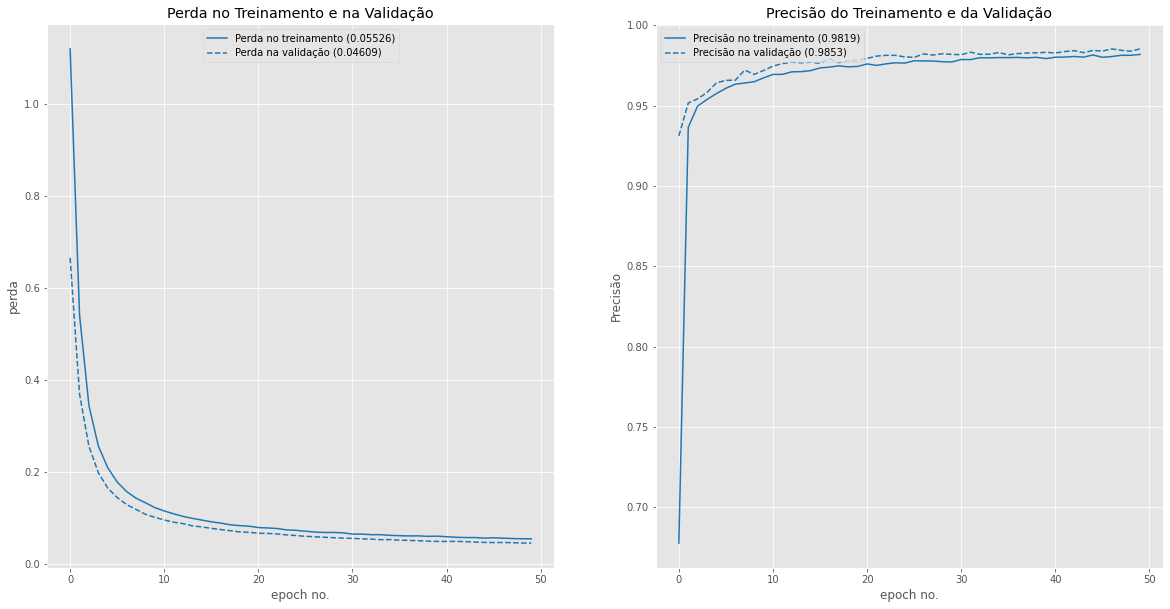

In [ ]:
training_configuration=TrainingConfiguration()
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

In [ ]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()
    

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [ ]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
        
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    #print(cls)
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
    
    os.chdir(training_configuration.dst_root)
    fig.savefig('sample_prediction.png')
    os.chdir(training_configuration.data_root)
    plt.show()
    
    return
        
    

In [ ]:
def get_all_prediction(model, data_root, mean, std,batch_size = 1000):
    

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
        
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    #test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    #interval = int(data_len/batch_size)
    
    #imgs = []
    inputs = []
    targets = []
    cls = []
    prob = []

    for i in range(data_len):
        #index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(i)
        
        inputs.append(trans_input)
        targets.append(target)
        if((i+1)%batch_size==0 or (i+1)==data_len):
            #print(i,batch_size,(i+1)%batch_size,data_len)
            inputs = torch.stack(inputs)
            cls_batch, prob_batch = prediction(model, device, batch_input=inputs)
            cls.extend(cls_batch)
            prob.extend(prob_batch)
            
            inputs = []
        #print(len(cls), len(prob),  len(targets), data_len)
   
    return targets, cls, prob
        
    

## <font style="color:blue">Load Model and Run Inference</font>

In [ ]:
train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'validation')

train_data_path = os.path.join(train_config.data_root, 'training')

m = pretrained_resnet50()
os.chdir(train_config.dst_root)
m = load_model(m)
os.chdir(train_config.data_root)




mean, std = get_mean_std(train_data_path)


#get_sample_prediction(m, test_data_path, mean, std)

mean: tensor([0.4989, 0.4909, 0.4811]), std: tensor([0.1985, 0.1947, 0.1935])


# <font style="color:red">Confusion Matrix</font>



In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matriz de confusão Normalizada'
        else:
            title = 'Matriz de confusão'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão')


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Rótulo Real',
           xlabel='Rótulo Previsto')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Matriz de confusão


<Figure size 3600x3600 with 0 Axes>

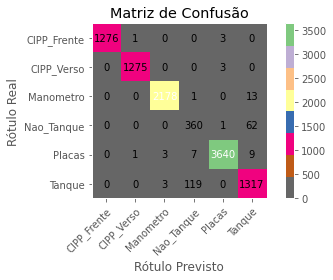

Matriz de confusão normalizada


<Figure size 7200x7200 with 0 Axes>

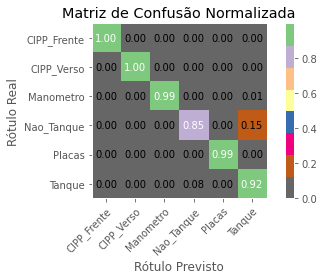

In [ ]:

# transformed data
test_dataset_trans = datasets.ImageFolder(root=test_data_path, transform=image_common_transforms(mean, std))

# original image dataset
test_dataset = datasets.ImageFolder(root=test_data_path, transform=image_preprocess_transforms())
'''
data_len = test_dataset.__len__()

if torch.cuda.is_available():
    device = "cuda"
    num_workers = 8
else:
    device = "cpu"
    num_workers = 2

imgs = []
inputs = []
targets = []
for i in range(data_len):
    #index = i * interval
    trans_input, target = test_dataset_trans.__getitem__(i)
    img, _ = test_dataset.__getitem__(i)
    
    imgs.append(img)
    inputs.append(trans_input) 
    targets.append(target)
    
inputs = torch.stack(inputs)
    
cls, prob = prediction(m, device, batch_input=inputs)
'''
targets, cls, prob=get_all_prediction(m, data_root=test_data_path, mean=mean, std=std,batch_size = 500)

# Plot non-normalized confusion matrix


plt.figure(figsize=(50,50))
plot_confusion_matrix(targets, cls, classes=test_dataset.classes, 
                      title='Matriz de Confusão',cmap=plt.cm.Accent_r) 
plt.grid(False)
os.chdir(train_config.dst_root)
plt.savefig('matriz_confusao_classe_6_n_normalized.png')
os.chdir(train_config.data_root)

plt.show()


plt.figure(figsize=(100,100))
plot_confusion_matrix(targets, cls, classes=test_dataset.classes, normalize='True',
                      title='Matriz de Confusão Normalizada',cmap=plt.cm.Accent_r) 
plt.grid(False)
os.chdir(train_config.dst_root)
plt.savefig('matriz_confusao_classe_6_normalized.png')
os.chdir(train_config.data_root)


Matriz de confusão


<Figure size 3600x3600 with 0 Axes>

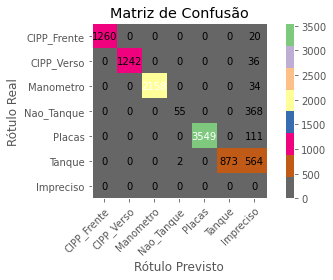

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


Matriz de confusão normalizada


<Figure size 7200x7200 with 0 Axes>

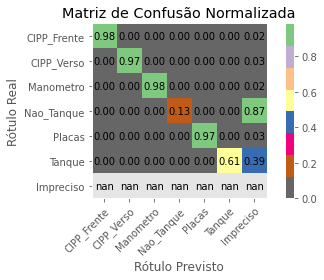

In [ ]:
m=load_model(m, model_file_name='/content/drive/My Drive/Resnet/8.2-classificacao_v5(6_classes)/6_classes/models/CIPP_classifier_6_classes_v5.pt')
classes=test_dataset.classes.copy()
classes.append('Impreciso')
cls_copy=cls.copy()
for i in range(len(cls)):
  if(prob[i]<0.95):
    cls_copy[i]=6


# Plot non-normalized confusion matrix


plt.figure(figsize=(50,50))
plot_confusion_matrix(targets, cls_copy, classes=classes, 
                      title='Matriz de Confusão',cmap=plt.cm.Accent_r) 
plt.grid(False)
os.chdir(train_config.dst_root)
plt.savefig('matriz_confusao_classe_6_n_normalized_95_confidence_v5.png')
os.chdir(train_config.data_root)

plt.show()


plt.figure(figsize=(100,100))
plot_confusion_matrix(targets, cls_copy, classes=classes, normalize='True',
                      title='Matriz de Confusão Normalizada',cmap=plt.cm.Accent_r) 
plt.grid(False)
os.chdir(train_config.dst_root)
plt.savefig('matriz_confusao_classe_6_normalized_95_confidence_v5.png')
os.chdir(train_config.data_root)



Matriz de confusão normalizada


<Figure size 3600x3600 with 0 Axes>

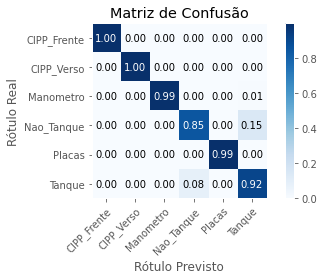

In [ ]:
fig = plt.figure(figsize=(50,50))
#fig = plt.figure()
training_configuration = TrainingConfiguration()

plot_confusion_matrix(targets, cls, classes=test_dataset.classes, normalize='True',
                      title='Matriz de Confusão',cmap=plt.cm.Blues) 
plt.grid(False)
os.chdir(training_configuration.dst_root)
plt.savefig('matriz_confusao_classe_6.png')
os.chdir(training_configuration.data_root)

plt.show()

